In [2]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# EXTRACTING the existing sample data

In [4]:
# Combining the point position information with their normal vectors.

with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    


# Step 1.1: Testing with Partial Spaces 

In [6]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = np.arange(0.5,2.1,0.5)

# We used 100 for our investigation
samples = 20

# 1.1.1 Testing our partial samples: Raw spaces

In [14]:
for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        
    partial_scores = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(triangles)#-vertices_length

        t1 = time.time()

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                t_pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 10 == (samples-1)%10:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RAW_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


 radius = 0.5: Done with 9 iterations. Time to match 8.164 seconds.
   Error Rate: 0.8888888888888888


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


 radius = 0.5: Done with 19 iterations. Time to match 8.185 seconds.
   Error Rate: 0.7894736842105261
0.5 Error Rate: 0.8000000000000003
 radius = 0.75: Done with 9 iterations. Time to match 10.428 seconds.
   Error Rate: 0.7777777777777777
 radius = 0.75: Done with 19 iterations. Time to match 8.712 seconds.
   Error Rate: 0.6842105263157894
0.75 Error Rate: 0.7000000000000002
 radius = 1.0: Done with 9 iterations. Time to match 8.780 seconds.
   Error Rate: 1.0
 radius = 1.0: Done with 19 iterations. Time to match 11.608 seconds.
   Error Rate: 0.7894736842105263
1.0 Error Rate: 0.8000000000000002


# 1.1.2 Testing our partial samples: RANSAC spaces

In [37]:
for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        
    partial_scores = []
    partial_properties = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(triangles)#-vertices_length

        #if object_name % 13 == 0:
        #    print('{}: Processing iteration {} of object {}.'.format(radius,iteration,object_name))

        t1 = time.time()

        # GETTING GENERALIZATION
        gen_planes = getRansacPlanes(
            t_pointCloud
        )

        p_pointcloud, p_triangles = getGeneralizedPointCloud(
            planes=gen_planes, 
        )

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                p_pointcloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            #o_, r_descriptors, r_keypoints, r_d_c
            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            #print('Processing iteration {} of object {}, comparing with {}.'.format(iteration,object_name,o_))

            # skip if descriptors are empty
    #        if len(p_descriptors) == 0:
    #            local_similarity_scores.append([0, # mean similarity
    #                                            len(p_descriptors), # number of partial descriptors
    #                                            len(r_descriptors), # number of reference descriptors
    #                                            0, # number of matches
    #                                           ])
                #local_bayesian_similarity.append(0)
    #            continue
            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 33== 1:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RANSAC_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


 radius = 0.5: Done with 1 iterations. Time to match 2.637 seconds.
   Error Rate: 1.0


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 Error Rate: 0.9500000000000002
 radius = 0.75: Done with 1 iterations. Time to match 1.933 seconds.
   Error Rate: 1.0
0.75 Error Rate: 1.0000000000000002
 radius = 1.0: Done with 1 iterations. Time to match 1.720 seconds.
   Error Rate: 1.0
1.0 Error Rate: 0.9500000000000002


# 1.1.3 Results of partial spaces

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: Mean of empty slice
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


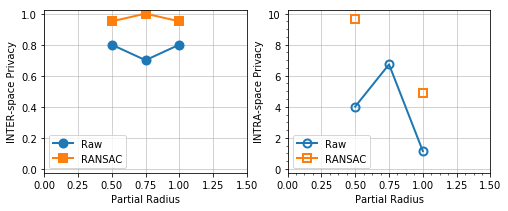

In [42]:
fig=plt.figure(figsize=(8, 3))

RawNN = []
RansacGeneralizedNN = []

RawNN_intra_errors = []
RansacGeneralizedNN_intra_errors = []

for radius in radius_range:
    
    try:
        with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RawNN.append([
            radius,
            np.mean(partial_errors[:,1]),
            np.std(partial_errors[:,1]),
        ])
        
        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RawNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
    try:
        with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RansacGeneralizedNN.append([
            radius,
            np.nanmean(partial_errors[:,1]),
            np.nanstd(partial_errors[:,1]),
        ])

        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RansacGeneralizedNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
RansacGeneralizedNN = np.asarray(RansacGeneralizedNN)
RawNN = np.asarray(RawNN)

RawNN_intra_errors = np.asarray(RawNN_intra_errors)
RansacGeneralizedNN_intra_errors = np.asarray(RansacGeneralizedNN_intra_errors)

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,1.5)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")
#ax1.set_yticklabels(fontsize = 16)
#ax1.set_xticklabels(fontsize = 16)

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    "-o",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "Raw"
)
ax1.plot(
    RansacGeneralizedNN[:,0],RansacGeneralizedNN[:,1],
    "-s",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax1.legend(loc = "lower left")

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,1.5)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

plt.minorticks_on()

ax2.plot(
    RawNN_intra_errors[:,0],
    RawNN_intra_errors[:,1], 
    linewidth = 2,
    marker = 'o',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "Raw"
)

ax2.plot(
    RansacGeneralizedNN_intra_errors[:,0],
    RansacGeneralizedNN_intra_errors[:,1], 
    linewidth = 2, 
    marker = 's',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax2.legend(loc = "lower left")

# Step 1.2 Testing with successively released partial spaces

In [50]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# We used 50 samples with further 100 successive releases for our investigation.
samples = 20
releases = 20

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

# 1.2.1 Testing the successive case: RAW and RANSAC

In [57]:
for radius in radius_range:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
    except:
        pass
    
    successive_scores = []
    successive_errors = []
    
    g_successive_scores = []
    g_successive_errors = []

    for obj_, growing_point_collection in successive_point_collection:
        
        iteration_scores = []
        
        g_iteration_scores = []
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        growing_point_cloud = []
        growing_p_point_cloud = []
        growing_p_triangles = []
        
        release_count = 0
    
        for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
            #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

            rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

            # TRANSLATION
            t_pointCloud = np.asarray(rotated_pointCloud)
            t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
            t_triangles = np.asarray(partial_triangles)#-vertices_length
            
            #Regular Accumulation
            if len(growing_point_cloud) == 0:
                growing_point_cloud = t_pointCloud

            else:
                growing_point_cloud = np.concatenate(
                    (growing_point_cloud,t_pointCloud),
                    axis=0
                )
                
            #RANSAC generalizations
            if len(growing_p_point_cloud) == 0:
                gen_planes = getLOCALIZEDRansacPlanes(
                    pointCloud = t_pointCloud,
                    original_vertex = obj_meta[-1]
                )
            else:
                gen_planes = updatePlanesWithSubsumption(
                    new_pointCloud=t_pointCloud,
                    existing_pointCloud=growing_p_point_cloud,
                    planes_to_find = max(min(release_count,50),30),
                    #verbose=True
                )
            
            if len(gen_planes) == 0:
                print("No gen planes after release",release_count,growing_point_cloud.shape)
                continue

            try:
                updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                    planes = gen_planes,
                    triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                    #verbose = True
                )
                growing_p_point_cloud = updated_point_cloud
                growing_p_triangles = updated_triangles
                
                #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
            except Exception as ex:
                print("Error getting updated point cloud in release",release_count+1)
                print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                #print(ex)
                continue
                
            if len(growing_p_point_cloud) == 0:
                continue
                
            release_count += 1
            
            if release_count % skip != 1: # skip 
                continue
                
            #Regular Processing
            growing_point_cloud = np.unique(growing_point_cloud,axis=0)
            
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {}: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(iteration_scores),
                    release_count,
                    len(successive_scores),
                    time.time()-t0,
                    growing_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(iteration_scores)
                print("   Error Rate:",np.sum(current_errors[:,1]/len(iteration_scores)))
            
            #RANSAC Processing         
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_p_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []
                
                print("Error getting descriptors at release",release_count,"; using next release as this release.")
                
                #release_count -= 1

                continue

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                #o_, r_descriptors, r_keypoints, r_d_c
                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            g_iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(g_iteration_scores),
                    release_count,
                    len(g_successive_scores),
                    time.time()-t0,
                    growing_p_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(g_iteration_scores)
                print("   G_Error Rate:",np.sum(current_errors[:,1]/len(g_iteration_scores)))

        iteration_errors = NN_matcher(iteration_scores)

        g_iteration_errors = NN_matcher(g_iteration_scores)

        if len(successive_scores) % 5 == (samples-1)%5 :
            try:
                print(radius,len(successive_scores),"Error Rate:",np.sum(iteration_errors[:,1]/len(iteration_scores)))
                print(radius,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
            except:
                pass
            
        successive_scores.append([
            obj_,
            iteration_scores
        ])
        
        successive_errors.append([
            obj_,
            iteration_errors
        ])
        
        g_successive_scores.append([
            obj_,
            g_iteration_scores
        ])
        
        g_successive_errors.append([
            obj_,
            g_iteration_errors
        ])
    
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_scores,f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_errors,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)

/Users/deg032/Projects/3D-spatial-privacy/info3d.py:889: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(firstPlane[1],point[3:])/(LA.norm(firstPlane[1])*LA.norm(point[3:]))) > (1-20*threshold):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:1011: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):


  radius = 0.5: Done with 2 releases (4) (0 samples). Time to match 6.199 seconds. ((552, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 1.843 seconds. ((570, 6))
   G_Error Rate: 0.5


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


  radius = 0.5: Done with 4 releases (10) (0 samples). Time to match 16.765 seconds. ((957, 6))
   Error Rate: 0.75
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 4.006 seconds. ((1020, 6))
   G_Error Rate: 0.75
  radius = 0.5: Done with 6 releases (16) (0 samples). Time to match 18.055 seconds. ((1116, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 5.738 seconds. ((1661, 6))
   G_Error Rate: 0.8333333333333333


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


  radius = 0.5: Done with 2 releases (4) (1 samples). Time to match 21.033 seconds. ((726, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (1 samples). Time to match 2.348 seconds. ((656, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (1 samples). Time to match 14.229 seconds. ((959, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (1 samples). Time to match 3.131 seconds. ((969, 6))
   G_Error Rate: 0.5
  radius = 0.5: Done with 6 releases (16) (1 samples). Time to match 22.238 seconds. ((1308, 6))
   Error Rate: 0.8333333333333333
  radius = 0.5 [G]: Done with 6 releases (16) (1 samples). Time to match 5.996 seconds. ((2225, 6))
   G_Error Rate: 0.6666666666666666
  radius = 0.5: Done with 2 releases (4) (2 samples). Time to match 28.750 seconds. ((1777, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 2 releases (4) (2 samples). Time to match 1.259 seconds. ((574, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 2 rel

  radius = 0.75 [G]: Done with 4 releases (10) (2 samples). Time to match 2.912 seconds. ((1060, 6))
   G_Error Rate: 0.75
  radius = 0.75: Done with 6 releases (16) (2 samples). Time to match 12.438 seconds. ((968, 6))
   Error Rate: 0.9999999999999999
  radius = 0.75 [G]: Done with 6 releases (16) (2 samples). Time to match 3.302 seconds. ((1250, 6))
   G_Error Rate: 0.8333333333333333
  radius = 0.75: Done with 2 releases (4) (3 samples). Time to match 15.249 seconds. ((689, 6))
   Error Rate: 1.0
  radius = 0.75 [G]: Done with 2 releases (4) (3 samples). Time to match 2.867 seconds. ((586, 6))
   G_Error Rate: 1.0
  radius = 0.75: Done with 4 releases (10) (3 samples). Time to match 14.256 seconds. ((1025, 6))
   Error Rate: 1.0
  radius = 0.75 [G]: Done with 4 releases (10) (3 samples). Time to match 3.997 seconds. ((931, 6))
   G_Error Rate: 0.75
  radius = 0.75: Done with 6 releases (16) (3 samples). Time to match 15.267 seconds. ((1174, 6))
   Error Rate: 0.9999999999999999
  r

/Users/deg032/Projects/3D-spatial-privacy/info3d.py:885: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(firstPlane[1],point[:3])+d)*1.0/LA.norm(firstPlane[1],ord = 2)) < threshold:
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:591: RuntimeWarning: invalid value encountered in double_scalars
  phi = math.fabs(plane_params[1][1]* 1./LA.norm(plane_params[1])) # y/r


  radius = 1.0: Done with 2 releases (4) (0 samples). Time to match 5.204 seconds. ((688, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 2 releases (4) (0 samples). Time to match 2.100 seconds. ((1126, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 4 releases (10) (0 samples). Time to match 11.218 seconds. ((837, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 4 releases (10) (0 samples). Time to match 2.608 seconds. ((1213, 6))
   G_Error Rate: 0.75
  radius = 1.0: Done with 6 releases (16) (0 samples). Time to match 11.176 seconds. ((861, 6))
   Error Rate: 0.9999999999999999
  radius = 1.0 [G]: Done with 6 releases (16) (0 samples). Time to match 2.694 seconds. ((1240, 6))
   G_Error Rate: 0.8333333333333333
  radius = 1.0: Done with 2 releases (4) (1 samples). Time to match 13.966 seconds. ((438, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 2 releases (4) (1 samples). Time to match 0.923 seconds. ((463, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 4 rel

  radius = 1.0: Done with 2 releases (4) (17 samples). Time to match 6.552 seconds. ((909, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 2 releases (4) (17 samples). Time to match 1.628 seconds. ((946, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 4 releases (10) (17 samples). Time to match 10.651 seconds. ((1045, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 4 releases (10) (17 samples). Time to match 2.098 seconds. ((1126, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done with 6 releases (16) (17 samples). Time to match 11.233 seconds. ((1295, 6))
   Error Rate: 0.9999999999999999
  radius = 1.0 [G]: Done with 6 releases (16) (17 samples). Time to match 3.573 seconds. ((1657, 6))
   G_Error Rate: 0.9999999999999999
  radius = 1.0: Done with 2 releases (4) (18 samples). Time to match 18.788 seconds. ((589, 6))
   Error Rate: 1.0
  radius = 1.0 [G]: Done with 2 releases (4) (18 samples). Time to match 1.918 seconds. ((648, 6))
   G_Error Rate: 1.0
  radius = 1.0: Done wi

# 1.2.2 Results of the successive case

In [8]:
succ_RawNN_errors = []
succ_RawNN_partial_errors = []

succ_RansacGeneralizedNN_errors = []
succ_RansacGeneralizedNN_partial_errors = []

t0 = time.time()

for radius in radius_range:
    
    succ_RawNN_per_iteration_errors = []
    succ_RansacGeneralizedNN_per_iteration_errors = []

    try:
                
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_errors in successive_errors:    
            #print("  RAW",radius,iteration_errors.shape)

            if iteration_errors.shape[0]<6:
                continue
            else:
                succ_RawNN_per_iteration_errors.append(iteration_errors[:6])
       
        succ_RawNN_errors.append([
            radius,
            np.asarray(succ_RawNN_per_iteration_errors)
        ])

    except:# Exception as ex:
        #print(radius,": successive RawNN\n  ", ex)
        pass
    
    try:
                
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_scores in successive_scores:#[:-1]:    
            #print("  RANSAC",radius,iteration_errors.shape)
            iteration_errors = NN_matcher(iteration_scores)

            if iteration_errors.shape[0] <6:
                continue
            else:
                succ_RansacGeneralizedNN_per_iteration_errors.append(iteration_errors[:6])
       
        succ_RansacGeneralizedNN_errors.append([
            radius,
            np.asarray(succ_RansacGeneralizedNN_per_iteration_errors)
        ])
          
    except:# Exception as ex:
        #print(radius,": successive RansacNN\n  ", ex)
        pass
    
    print("Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()
    
for radius, per_iteration_errors in succ_RawNN_errors:

    #print(per_iteration_errors.shape)

    succ_RawNN_partial_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RawNN_partial_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RawNN_partial_errors.append([
        radius,
        np.asarray(succ_RawNN_partial_errors_per_rel)
    ])
    
for radius, per_iteration_errors in succ_RansacGeneralizedNN_errors:

    #print(radius,per_iteration_errors.shape)

    succ_RansacGeneralizedNN_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RansacGeneralizedNN_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RansacGeneralizedNN_partial_errors.append([
        radius,
        np.asarray(succ_RansacGeneralizedNN_errors_per_rel)
    ])
    
len(succ_RansacGeneralizedNN_partial_errors)

Done with radius = 0.50 in 0.063 seconds
Done with radius = 1.00 in 0.098 seconds
Done with radius = 1.50 in 0.000 seconds
Done with radius = 2.00 in 0.000 seconds


/Users/deg032/Projects/public/spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', su

2

NameError: name 'releases' is not defined

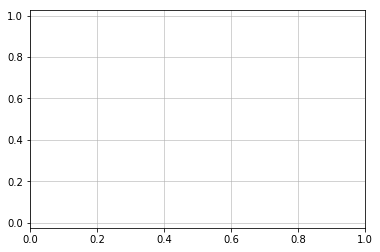

In [9]:

plt.grid(alpha = 0.7)
plt.ylim(-0.025,1.025)
plt.xlim(0,releases)#-2,102)

markersize = 8

plt.ylabel("Average Privacy", fontsize = 16)
plt.xlabel("Releases", fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

for radius, RawNN_per_iteration_errors in succ_RawNN_errors:
    print(RawNN_per_iteration_errors.shape)
    plt.plot(
        np.arange(1,releases-skip,skip),#[:RawNN_per_iteration_errors.shape[1]],
        np.mean(RawNN_per_iteration_errors[:,:,1], axis = 0), 
        label = str(radius) + " Raw"
    )
    
for radius, RansacNN_per_iteration_errors in succ_RansacGeneralizedNN_errors:
    print(RansacNN_per_iteration_errors.shape)
    plt.plot(
        np.arange(1,releases-skip,skip),
        np.mean(RansacNN_per_iteration_errors[:,:,1], axis = 0), 
        label = str(radius) + " RANSAC"
    )

#plt.title("Successive (Random)", fontsize = 16)
plt.legend(ncol = 2)


(8, 6, 3)
(10, 6, 3)
(12, 6, 3)
(8, 6, 3)
(10, 6, 3)
(12, 6, 3)


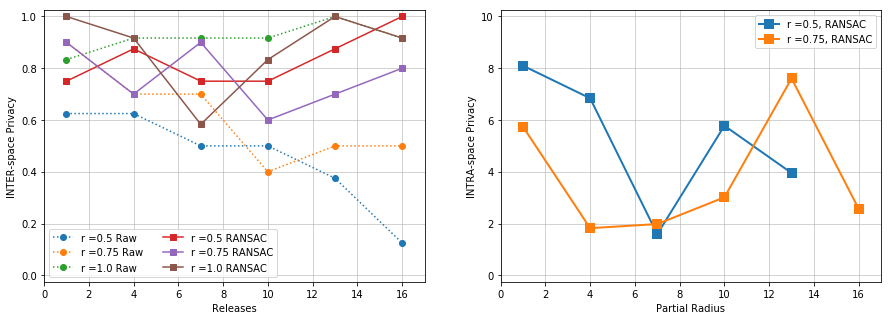

In [92]:
fig=plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,releases-skip)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Releases")
#ax1.set_yticklabels(fontsize = 16)
#ax1.set_xticklabels(fontsize = 16)

for radius, RawNN_per_iteration_errors in succ_RawNN_errors:
    print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),#[:RawNN_per_iteration_errors.shape[1]],
        np.mean(RawNN_per_iteration_errors[:,:,1], axis = 0), 
        ':o',
        label = "r ="+ str(radius) + " Raw"
    )
    
for radius, RansacNN_per_iteration_errors in succ_RansacGeneralizedNN_errors:
    print(RansacNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),
        np.mean(RansacNN_per_iteration_errors[:,:,1], axis = 0),
        '-s',
        label = "r ="+ str(radius) + " RANSAC"
    )

ax1.legend(loc = "best", ncol = 2)

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,releases-skip)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

for radius, errors_per_rel in succ_RansacGeneralizedNN_partial_errors[:2]:
    ax2.plot(
        np.arange(1,releases-skip,skip),
        errors_per_rel[:,1], 
        #errors_per_rel[:,2],
        '-s',
        linewidth = 2, #capsize = 4.0, 
        #marker = markers[0],
        #fillstyle = 'none',
        mew = 2, markersize = markersize,
        label = "r ="+ str(radius)+", RANSAC"
    )

ax2.legend(loc = "best")

# Step 2.3 Testing with conservative plane releasing

In [93]:
"""
Parameters:

Also, we use the same successive samples from successive releasing for direct comparability of results.
"""
planes = np.arange(1,30,3)

In [ ]:
for radius in radius_range:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
    except:
        pass
    
    g_successive_scores = []
    g_successive_errors = []
    
    for obj_, growing_point_collection in successive_point_collection:
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        per_plane_successive_scores = []
        per_plane_successive_errors = []
        
        latest_plane = 0
        
        for plane_number in planes:
            
            print(" {} planes, ({} Done)".format(plane_number,len(per_plane_successive_scores)))
        
            g_iteration_scores = []

            growing_point_cloud = []
            growing_p_point_cloud = []
            growing_p_triangles = []

            release_count = 0
            
            for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
                #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

                # ROTATION
                rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

                # TRANSLATION
                t_pointCloud = np.asarray(rotated_pointCloud)
                t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
                t_triangles = np.asarray(partial_triangles)#-vertices_length

                #RANSAC generalizations
                try:
                    if len(growing_p_point_cloud) == 0:
                        gen_planes = getLOCALIZEDRansacPlanes(
                            pointCloud = t_pointCloud,#np.where(hPointConnectivity < 5)[0],axis = 0),
                            original_vertex = obj_meta[-1],
                            planes_to_find=plane_number
                            #verbose=True
                            #threshold = threshold # the point-plane distance threshold
                        )
                    else:
                        gen_planes = updatePlanesWithSubsumption(
                            new_pointCloud=t_pointCloud,
                            existing_pointCloud=growing_p_point_cloud,
                            planes_to_find = plane_number
                            #verbose=True
                        )
                except:
                    print("Error getting planes",release_count,growing_point_cloud.shape)
                    continue

                if len(gen_planes) == 0:
                    print("No gen planes after release",release_count,growing_point_cloud.shape)
                    continue

                try:
                    updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                        planes = gen_planes,
                        triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                        #verbose = True
                    )
                    growing_p_point_cloud = updated_point_cloud
                    growing_p_triangles = updated_triangles

                    #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
                except Exception as ex:
                    print("Error getting updated point cloud in release",release_count+1)
                    print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                    #print(ex)
                    continue

                if len(growing_p_point_cloud) == 0:
                    continue

                release_count += 1

                if release_count % skip != 1: # skip if not 5th accumulated release
                    continue

                #RANSAC Processing         
                try:
                    p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                        growing_p_point_cloud,
                        down_resolution = 5,
                        cylindrical_quantization = [4,5]
                    )
                except:
                    p_descriptors = []
                    p_keypoints = []

                    print("Error getting descriptors at release",release_count,"; using next release as this release.")

                    #release_count -= 1

                    continue

                # Resetting the diff_Ratio matrix
                diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
                diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
                diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

                local_keypoint_matches = []

                for i_r, ref_descriptor in enumerate(descriptors):

                    #o_, r_descriptors, r_keypoints, r_d_c
                    r_descriptors = ref_descriptor[1]
                    r_keypoints = ref_descriptor[2]

                    matching_range = np.arange(r_descriptors.shape[1])

                    try:    
                        f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                        diff = diff/np.amax(diff) # max-normalization of differences
                        diff_ratio = diff[:,0]/diff[:,1]
                        diff_ratios[:,i_r] = diff_ratio
                        diff_scores[:,i_r] = diff
                        diff_indexs[:,i_r] = f_nearestneighbor

                        # Taking note of the matched keypoints
                        local_keypoint_matches.append([
                            obj_meta,
                            p_keypoints,
                            r_keypoints[f_nearestneighbor[:,0]]
                        ])

                    except Exception as ex:
                        print(rotation,"Error Matching:",ex)

                # Accumulating the diff_ratio matrix for every partial (rotated) object
                g_iteration_scores.append([
                    obj_meta,
                    diff_ratios,
                    diff_indexs,
                    diff_scores,
                    local_keypoint_matches
                ])

        # --- !
                if release_count % 2 == 0:
                    #print('Test')
                    print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                        radius,
                        len(g_iteration_scores),
                        release_count,
                        len(g_successive_scores),
                        time.time()-t0,
                        growing_p_point_cloud.shape
                    )
                         )
                    t0 = time.time()

                    current_errors = NN_matcher(g_iteration_scores)
                    print("   ({} actual planes) G_Error Rate: {}".format(
                        len(gen_planes),
                        np.sum(current_errors[:,1]/len(g_iteration_scores))
                    ))

                g_iteration_errors = NN_matcher(g_iteration_scores)
            try:
                print(radius,plane_number,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
            except:
                pass

            per_plane_successive_scores.append([
                plane_number,
                g_iteration_scores
            ])

            per_plane_successive_errors.append([
                plane_number,
                g_iteration_errors
            ])

        g_successive_scores.append([
            obj_,
            per_plane_successive_scores
        ])

        g_successive_errors.append([
            obj_,
            per_plane_successive_errors
        ])
        
        if len(successive_scores) % 5 == (samples-1)%5 :
            try:
                print("Radius = {}, {} objects done".format(radius,len(g_successive_scores)))
            except:
                pass
            
        with open('testing_results/conservative/radius_{}_RANSAC_conservative_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)
                

 1 planes, (0 Done)


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:889: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(firstPlane[1],point[3:])/(LA.norm(firstPlane[1])*LA.norm(point[3:]))) > (1-20*threshold):
/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:1011: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):


  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 2.686 seconds. ((353, 6))
   (1 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 4.865 seconds. ((519, 6))
   (1 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 6.156 seconds. ((538, 6))
   (1 actual planes) G_Error Rate: 0.6666666666666666
0.5 1 0 G_Error Rate: 0.6666666666666666
 4 planes, (1 Done)


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 3.648 seconds. ((561, 6))
   (3 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 8.870 seconds. ((1979, 6))
   (4 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 11.258 seconds. ((2153, 6))
   (4 actual planes) G_Error Rate: 0.6666666666666666
0.5 4 0 G_Error Rate: 0.7142857142857142
 7 planes, (2 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (0 samples). Time to match 10.779 seconds. ((548, 6))
   (2 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (0 samples). Time to match 7.693 seconds. ((1143, 6))
   (3 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (0 samples). Time to match 10.877 seconds. ((1299, 6))
   (3 actual planes) G_Error Rate: 0.8333333333333333
0.5 7 0 G_Error Rate: 0.857142857142857
 10 planes, (3 Done)
  radius = 0.5

0.5 22 1 G_Error Rate: 0.857142857142857
 25 planes, (8 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (1 samples). Time to match 18.339 seconds. ((721, 6))
   (5 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (1 samples). Time to match 12.545 seconds. ((1436, 6))
   (6 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 6 releases (16) (1 samples). Time to match 16.128 seconds. ((2361, 6))
   (9 actual planes) G_Error Rate: 0.9999999999999999
0.5 25 1 G_Error Rate: 0.9999999999999998
 28 planes, (9 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (1 samples). Time to match 14.956 seconds. ((709, 6))
   (5 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (1 samples). Time to match 11.176 seconds. ((1320, 6))
   (7 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 6 releases (16) (1 samples). Time to match 17.641 seconds. ((2504, 6))
   (10 actual planes) G_Error Rate: 0.9999999999999999
0.5 28 1

  radius = 0.5 [G]: Done with 6 releases (16) (3 samples). Time to match 10.030 seconds. ((1185, 6))
   (4 actual planes) G_Error Rate: 0.6666666666666666
0.5 13 3 G_Error Rate: 0.7142857142857142
 16 planes, (5 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (3 samples). Time to match 9.842 seconds. ((496, 6))
   (3 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (3 samples). Time to match 7.760 seconds. ((975, 6))
   (5 actual planes) G_Error Rate: 0.5
  radius = 0.5 [G]: Done with 6 releases (16) (3 samples). Time to match 11.759 seconds. ((1232, 6))
   (5 actual planes) G_Error Rate: 0.6666666666666666
0.5 16 3 G_Error Rate: 0.5714285714285714
 19 planes, (6 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (3 samples). Time to match 11.318 seconds. ((500, 6))
   (3 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (3 samples). Time to match 6.948 seconds. ((910, 6))
   (3 actual planes) G_Error Rate: 1.0
  radius = 0.

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:182: RuntimeWarning: divide by zero encountered in true_divide
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:182: RuntimeWarning: invalid value encountered in true_divide


  radius = 0.5 [G]: Done with 2 releases (4) (4 samples). Time to match 11.382 seconds. ((452, 6))
   (3 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (4 samples). Time to match 4.535 seconds. ((528, 6))
   (3 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (4 samples). Time to match 5.974 seconds. ((676, 6))
   (3 actual planes) G_Error Rate: 0.8333333333333333
0.5 4 4 G_Error Rate: 0.857142857142857
 7 planes, (2 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (4 samples). Time to match 8.360 seconds. ((478, 6))
   (5 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (4 samples). Time to match 6.474 seconds. ((835, 6))
   (6 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 6 releases (16) (4 samples). Time to match 8.451 seconds. ((1034, 6))
   (6 actual planes) G_Error Rate: 0.8333333333333333
0.5 7 4 G_Error Rate: 0.857142857142857
 10 planes, (3 Done)
  radius = 0.5 [G]: 

  radius = 0.5 [G]: Done with 6 releases (16) (5 samples). Time to match 9.813 seconds. ((1170, 6))
   (8 actual planes) G_Error Rate: 0.6666666666666666
0.5 25 5 G_Error Rate: 0.7142857142857142
 28 planes, (9 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (5 samples). Time to match 11.696 seconds. ((522, 6))
   (4 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (5 samples). Time to match 11.239 seconds. ((1147, 6))
   (7 actual planes) G_Error Rate: 0.75
  radius = 0.5 [G]: Done with 6 releases (16) (5 samples). Time to match 10.839 seconds. ((1211, 6))
   (8 actual planes) G_Error Rate: 0.8333333333333333
0.5 28 5 G_Error Rate: 0.857142857142857
 1 planes, (0 Done)
0.5 1 6 G_Error Rate: nan
 4 planes, (1 Done)
  radius = 0.5 [G]: Done with 2 releases (4) (6 samples). Time to match 11.610 seconds. ((372, 6))
   (3 actual planes) G_Error Rate: 1.0
  radius = 0.5 [G]: Done with 4 releases (10) (6 samples). Time to match 6.367 seconds. ((505, 6))
   (3